# Decompose BERT Layer
The huggingface transformers library gives us pretrained Bert models that generate our ground truth results. This notebook decomposes the operations that happen in a Bert encoder layer to show exactly what our design must accelerate.

## Ground Truth

In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import math

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Our text input must first be tokenized, which uses Bert's dictionary to turn words into numbers.

In [3]:
# Input is the first 512 tokens generated from the proposal for this project.
text = 'This project aims to implement a transformer layer on a cluster of FPGAs. In recent years transformers have outperformed traditional convolutional neural networks in many fields, but serial performance is dismal and parallel GPU performance is power-intensive. Specialized architectures have been studied little, especially using FPGA platforms. This research will improve transformer inference performance by offloading computationally intensive sections of the network to reconfigurable accelerators running on a cluster of multiple FPGA devices. This research will result in an acceleration architecture for a single layer of a transformer network along with a performance comparison with CPU and GPU baselines. We propose the investigation of distributed transformer inference across a cluster of multiple field programmable gate arrays (FPGAs). This research will investigate the partitioning of a transformer layer across multiple FPGA devices along with networking between FPGAs in the cluster. Transformers have become a dominant machine learning architecture for many domains such as natural language processing, therefore high speed inference is desirable. However, networks sizes and limited FPGA resources often make inference on a single FPGA slow due to limited parallelism and pipeline depth or impossible due to limited resources. The purpose of this research is to explore methods to overcome these challenges by introducing parallelism through multi-FPGA clusters. Transformers are highly parallel neural network architectures which consist of stacks of encoder and decoder layers. These layers consist of many linear transformations on matrices which are represented by matrix-matrix multiplication. Within an encoder/decoder layer there is an opportunity to parallelize both between concurrent general matrix multiplies (GeMM) and within each GeMM. Attempting to serialize these operations on a CPU leads to high execution time and is a poor utilization of the CPU\'s general purpose architecture. GPUs can deliver high throughput inference for transformers, though they are power-hungry and do not achieve the low latency required by some applications. Both in the datacenter and at the edge, low-latency and efficient inference is desired. Optimally, there would be an architecture that could scale between these two extremes of computational demand. State-of-the-art transformers can contain upwards of 12 layers and multiply matrices on the order of 1024x1024 elements. In addition, the trend of increasing transformer size does not show signs of slowing. This large use of memory and FLOPs leads to difficulty mapping an entire transformer network to a '
encoded_input = tokenizer(text, return_tensors='pt')
encoded_input['input_ids'].shape

torch.Size([1, 512])

This output hidden state is what we want to validate against. After passing this tokenized input through BERT's embedder and it's 12 encoder layers, this is the result. We want to show that our implementation yields the same `last_hidden_state`.

In [4]:
output = model(**encoded_input)
output.last_hidden_state.shape, output.last_hidden_state

(torch.Size([1, 512, 768]),
 tensor([[[-3.7457e-01, -6.9887e-01, -4.4100e-04,  ..., -3.0715e-01,
           -3.8659e-01,  4.7352e-01],
          [-6.7209e-01, -7.5042e-01, -6.9455e-01,  ...,  1.4919e-01,
            1.1460e+00,  1.7025e-01],
          [-8.8504e-01, -6.3164e-01, -5.9148e-01,  ...,  2.0482e-01,
            1.7474e-01,  2.4267e-01],
          ...,
          [-2.5008e-01,  4.4047e-02, -2.1806e-01,  ...,  1.0060e-01,
            2.7695e-01,  8.8145e-01],
          [-7.5948e-01,  7.5723e-02, -3.9088e-01,  ..., -4.3433e-01,
            2.8015e-01,  7.4720e-01],
          [-3.3422e-01, -5.3718e-02,  5.4829e-01,  ...,  5.3513e-01,
           -3.9397e-01, -2.6217e-01]]], grad_fn=<NativeLayerNormBackward0>))

## Our Attention and FFN Implementation

In [40]:
def attention(layer, hidden_states):
    '''
    hidden_states: <bs, seqlen, dmodel>
    '''
    bs, seqlen, dmodel = hidden_states.size()
    num_heads = layer.attention.self.num_attention_heads
    dhead = layer.attention.self.attention_head_size
    
    # Linear transform to get multiple heads. This is a major MAC slurper.
    query_layer = layer.attention.self.query(hidden_states) # <bs, seqlen, dmodel>
    key_layer = layer.attention.self.key(hidden_states)     # <bs, seqlen, dmodel>
    value_layer = layer.attention.self.value(hidden_states) # <bs, seqlen, dmodel>
    
    # Reshape and transpose for multi-head
    new_shape = (bs, seqlen, num_heads, dhead)
    
    query_layer = query_layer.view(new_shape)
    key_layer = key_layer.view(new_shape)
    value_layer = value_layer.view(new_shape)
    
    query_layer = query_layer.permute(0,2,1,3) # <bs, num_head, seqlen, dhead>
    key_layer = key_layer.permute(0,2,3,1)     # <bs, num_head, dhead, seqlen>
    value_layer = value_layer.permute(0,2,1,3) # <bs, num_head, seqlen, dhead>
    
    # The attention main course
    attention_scores = torch.matmul(query_layer, key_layer)
    attention_scores /= math.sqrt(dhead)
    
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)
    attention_probs = layer.attention.self.dropout(attention_probs)
    
    attention_out = torch.matmul(attention_probs, value_layer)
    
    attention_out = attention_out.permute(0,2,1,3).contiguous()
    attention_out = attention_out.view(bs, seqlen, dmodel)
    
    # It's time for one more linear transform and layer norm
    dense_out = layer.attention.output.dense(attention_out)
    dense_out = layer.attention.output.dropout(dense_out)
    # Implements the residual connection
    layer_out = layer.attention.output.LayerNorm(dense_out + hidden_states)
    
    return layer_out
    
    
attention_out = attention(model.encoder.layer[0], embedding_output)
ff_out = ffn(model.encoder.layer[0], attention_out)

In [44]:
def ffn(layer, attention_out):
    
    # Layer 1
    output = layer.intermediate.dense(attention_out)
    output = nn.functional.gelu(output)
    
    # Layer 2
    output = layer.output.dense(output)
    output = layer.output.dropout(output)
    output = layer.output.LayerNorm(output + attention_out)
    
    return output

### Show that it gives the same output
The cell below loops through each encoder layer in the pretrained Bert model and calls our `attention` and `ffn` implementations on the hidden state. 

In [47]:
hidden_states = embedding_output

for layer_module in model.encoder.layer:
    # MHA + LayerNorm
    attention_out = attention(layer_module, hidden_states)
    ff_out = ffn(layer_module, attention_out)
    hidden_states = ff_out
    
print(hidden_states)

tensor([[[-3.7457e-01, -6.9887e-01, -4.4100e-04,  ..., -3.0715e-01,
          -3.8659e-01,  4.7352e-01],
         [-6.7209e-01, -7.5042e-01, -6.9455e-01,  ...,  1.4919e-01,
           1.1460e+00,  1.7025e-01],
         [-8.8504e-01, -6.3164e-01, -5.9148e-01,  ...,  2.0482e-01,
           1.7474e-01,  2.4267e-01],
         ...,
         [-2.5008e-01,  4.4047e-02, -2.1806e-01,  ...,  1.0060e-01,
           2.7695e-01,  8.8145e-01],
         [-7.5948e-01,  7.5723e-02, -3.9088e-01,  ..., -4.3433e-01,
           2.8015e-01,  7.4720e-01],
         [-3.3422e-01, -5.3718e-02,  5.4829e-01,  ...,  5.3513e-01,
          -3.9397e-01, -2.6217e-01]]], grad_fn=<NativeLayerNormBackward0>)


In [51]:
'''
Verify equality
'''

torch.isclose(hidden_states, model(**encoded_input).last_hidden_state).all()

tensor(True)

### Step 1: Explicitly call model.embeddings and model.encoder
Now, do what BERT does in the forward pass, but explicitly.

In [5]:
embedding_output = model.embeddings(
    input_ids=encoded_input['input_ids'],
    position_ids=None,
    token_type_ids=encoded_input['token_type_ids'],
    inputs_embeds=None,
    past_key_values_length=0,
)

This is the input data we are now working with. It has gone through the encoder.

In [43]:
embedding_output

tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.6485,  0.6739, -0.0932,  ...,  0.4475,  0.6696,  0.1820],
         [ 0.3184,  0.3346, -0.0722,  ...,  0.0517, -0.0069, -0.7439],
         ...,
         [ 0.7621,  0.5828, -0.0454,  ...,  0.3383,  0.0191, -0.0997],
         [ 0.9247,  0.4532,  0.6505,  ..., -0.0661, -0.1281, -0.0595],
         [-0.2301, -0.4165,  0.3172,  ..., -0.2481,  0.5677, -1.6841]]],
       grad_fn=<NativeLayerNormBackward0>)

Now pass it through the encoder layers, all 12 of them.

In [7]:
head_mask = model.get_head_mask(None, model.config.num_hidden_layers)
extended_attention_mask = model.get_extended_attention_mask(attention_mask=encoded_input['attention_mask'],
                                                            input_shape=encoded_input['input_ids'].size(),
                                                            device=encoded_input['input_ids'].device)

In [8]:
encoder_outputs = model.encoder(
    embedding_output,
    attention_mask=extended_attention_mask,
    head_mask=head_mask,
    encoder_hidden_states=None,
    encoder_attention_mask=None,
    past_key_values=None,
    use_cache=None,
    output_attentions=None,
    output_hidden_states=None,
    return_dict=None,
)

Notice that we got the same result that we did when calling `model.forward()` at the beginning.

In [9]:
encoder_outputs

(tensor([[[-3.7457e-01, -6.9887e-01, -4.4100e-04,  ..., -3.0715e-01,
           -3.8659e-01,  4.7352e-01],
          [-6.7209e-01, -7.5042e-01, -6.9455e-01,  ...,  1.4919e-01,
            1.1460e+00,  1.7025e-01],
          [-8.8504e-01, -6.3164e-01, -5.9148e-01,  ...,  2.0482e-01,
            1.7474e-01,  2.4267e-01],
          ...,
          [-2.5008e-01,  4.4047e-02, -2.1806e-01,  ...,  1.0060e-01,
            2.7695e-01,  8.8145e-01],
          [-7.5948e-01,  7.5723e-02, -3.9088e-01,  ..., -4.3433e-01,
            2.8015e-01,  7.4720e-01],
          [-3.3422e-01, -5.3718e-02,  5.4829e-01,  ...,  5.3513e-01,
           -3.9397e-01, -2.6217e-01]]], grad_fn=<NativeLayerNormBackward0>),)

Can you replicate this `encoder_outputs` result very simply?

### Step 2: Call each encoder layer's `forward`

In [10]:
hidden_states = embedding_output
for layer_module in model.encoder.layer:
    layer_outputs = layer_module(hidden_states)
    hidden_states = layer_outputs[0]

Yes! Call each layer's `forward()`.

In [11]:
hidden_states

tensor([[[-3.7457e-01, -6.9887e-01, -4.4100e-04,  ..., -3.0715e-01,
          -3.8659e-01,  4.7352e-01],
         [-6.7209e-01, -7.5042e-01, -6.9455e-01,  ...,  1.4919e-01,
           1.1460e+00,  1.7025e-01],
         [-8.8504e-01, -6.3164e-01, -5.9148e-01,  ...,  2.0482e-01,
           1.7474e-01,  2.4267e-01],
         ...,
         [-2.5008e-01,  4.4047e-02, -2.1806e-01,  ...,  1.0060e-01,
           2.7695e-01,  8.8145e-01],
         [-7.5948e-01,  7.5723e-02, -3.9088e-01,  ..., -4.3433e-01,
           2.8015e-01,  7.4720e-01],
         [-3.3422e-01, -5.3718e-02,  5.4829e-01,  ...,  5.3513e-01,
          -3.9397e-01, -2.6217e-01]]], grad_fn=<NativeLayerNormBackward0>)

How low can we go?

### Step 3: For each layer, call it's submodules

In [12]:
hidden_states = embedding_output
for layer_module in model.encoder.layer:
    # MHA + LayerNorm
    self_attn_out = layer_module.attention(hidden_states)
    attn_out = self_attn_out[0]
    # First FF
    intermediate_out = layer_module.intermediate(attn_out)
    # Second FF + LayerNorm
    layer_out = layer_module.output(intermediate_out, attn_out)
    hidden_states = layer_out
    

In [13]:
hidden_states.shape, hidden_states

(torch.Size([1, 512, 768]),
 tensor([[[-3.7457e-01, -6.9887e-01, -4.4100e-04,  ..., -3.0715e-01,
           -3.8659e-01,  4.7352e-01],
          [-6.7209e-01, -7.5042e-01, -6.9455e-01,  ...,  1.4919e-01,
            1.1460e+00,  1.7025e-01],
          [-8.8504e-01, -6.3164e-01, -5.9148e-01,  ...,  2.0482e-01,
            1.7474e-01,  2.4267e-01],
          ...,
          [-2.5008e-01,  4.4047e-02, -2.1806e-01,  ...,  1.0060e-01,
            2.7695e-01,  8.8145e-01],
          [-7.5948e-01,  7.5723e-02, -3.9088e-01,  ..., -4.3433e-01,
            2.8015e-01,  7.4720e-01],
          [-3.3422e-01, -5.3718e-02,  5.4829e-01,  ...,  5.3513e-01,
           -3.9397e-01, -2.6217e-01]]], grad_fn=<NativeLayerNormBackward0>))

### Step 4: Implement the layer's operations
Now we use the model just as a repository of each layer's weights. Implement the linear transform, multi-head attention, feedforward, and layernorm. The cell below shows the parameters in one encoder layer.

In [14]:
model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [38]:
model.config.hidden_act

'gelu'

 asdf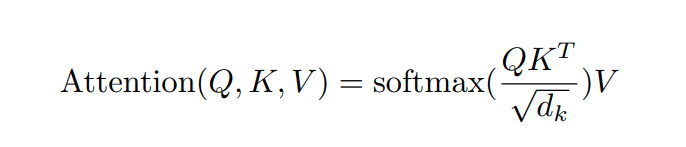